In [69]:
#initialization 
import matplotlib.pyplot as plt
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator

#import basic plot tools
from qiskit.visualization import plot_histogram

In [70]:
def initialize_s(qc, qubits):
    '''Apply H-gate to the qubits in "qubits"'''
    qc.h(qubits)

In [71]:
def phase_oracle(num_qubits, marked_states):
    '''Returns a phase_oracel circuit'''
    qc = QuantumCircuit(num_qubits, name="phase-oracle")
    oracle_matrix = np.identity(2**n)
    for q in marked_states:
        oracle_matrix[q, q] = -1
    print(oracle_matrix)
    Uf = Operator(oracle_matrix)
    qc.unitary(Uf, range(num_qubits))
    return qc

qc = phase_oracle(2, [0])
qc.draw()

[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


┌──────────┐
q_0: ┤0         ├
     │  unitary │
q_1: ┤1         ├
     └──────────┘

In [72]:
def phase_oracle_11():
    '''Return a phase oracle for the marked state |11>'''
    qc = QuantumCircuit(2, name="phase-oracle-|11>")
    qc.cz(control_qubit=0, target_qubit=1)
    return qc

In [73]:
def diffuser_2():
    '''Return a diffuser for a 2 qubit circuit'''
    qc = QuantumCircuit(2, name="diffuser-2")
    qc.h([0,1])
    qc.z([0,1])
    qc.cz(control_qubit=0, target_qubit=1)
    qc.h([0,1])
    return qc

qc = diffuser_2()
qc.draw()
    

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

In [74]:
def diffuser(num_qubits):
    '''Returns a diffuser circuit'''
    qc = QuantumCircuit(num_qubits, name="diffuser")
    qc.h(range(num_qubits))
    qc.append(phase_oracle(num_qubits, [0]), range(n))
    qc.h(range(num_qubits))
    return qc

In [75]:
def Grover(num_qubits, marked_states):
    '''Returns a quantum circuit for Grover's algorithm'''
    qc = QuantumCircuit(num_qubits, num_qubits, name="Grover")

    initialize_s(qc, range(num_qubits))
    #qc.barrier()
    m = len(marked_states)
    r = int(np.pi/4*np.sqrt(2**n/len(marked_states)) - 0.5)
    print("{0} repetitions will be performed, given {1} qubits and {2} marked state(s)".format(r, num_qubits, m))

    for iteration in range(r):
        qc.append(phase_oracle(num_qubits, marked_states), range(num_qubits))
        qc.append(diffuser(num_qubits), range(num_qubits))

    #qc.barrier()
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

In [76]:
def Grover_11():
    '''Returns a quantum circuit for Grover's algorithm for the
    marked state |11>'''
    qc = QuantumCircuit(2,2)
    initialize_s(qc, [0,1])
    qc.append(phase_oracle_11(), [0,1])
    qc.append(diffuser_2(), [0,1])
    
    qc.measure([0,1], [0,1])
    return qc

In [77]:
n = 2
#grover_circuit = Grover_11() 
grover_circuit = QuantumCircuit(2,2)
grover_circuit.h([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
#QuantumCircuit(n, n)
#grover_circuit.append(Grover(n, [0]), range(n))
grover_circuit = grover_circuit.decompose()
grover_circuit.draw('text', initial_state=True)


┌──────────┐          ┌──────────┐ ┌────────┐                     »
q_0: |0>┤ U2(0,pi) ├───────■──┤ U2(0,pi) ├─┤ U1(pi) ├──────────────────■──»
        ├──────────┤┌───┐┌─┴─┐└──┬───┬───┘┌┴────────┴┐┌────────┐┌───┐┌─┴─┐»
q_1: |0>┤ U2(0,pi) ├┤ H ├┤ X ├───┤ H ├────┤ U2(0,pi) ├┤ U1(pi) ├┤ H ├┤ X ├»
        └──────────┘└───┘└───┘   └───┘    └──────────┘└────────┘└───┘└───┘»
 c: 0 2/══════════════════════════════════════════════════════════════════»
                                                                          »
«     ┌──────────┐            
«q_0: ┤ U2(0,pi) ├────────────
«     └──┬───┬───┘┌──────────┐
«q_1: ───┤ H ├────┤ U2(0,pi) ├
«        └───┘    └──────────┘
«c: 2/════════════════════════
«

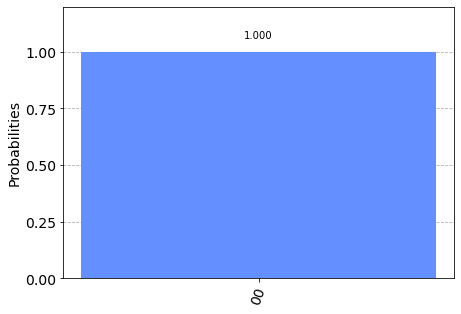

In [78]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_circuit, backend=simulator, shots=1000).result().get_counts(grover_circuit)
plot_histogram(counts)

In [82]:
from qiskit.circuit.random import random_circuit

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_lima')
qx = random_circuit(n_qubits=5, depth=4)
transpiled = transpile(qx, backend=backend)
myobj = assemble(transpiled)
job = backend.run(myobj)
retrieved_job = backend.retrieve_job(job.job_id())

In [79]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))                                  
print("Running on current least busy device: ", device)

C:\Users\ivash\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2022-04-01 17:28:33,103: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_belem


In [86]:
from qiskit.tools.monitor import job_monitor
device = provider.get_backend('ibmq_lima')
transpiled_grover_circuit = transpile(grover_circuit, backend=device)
transpiled_grover_circuit.draw()
job = device.run(assemble(transpiled_grover_circuit))
job_monitor(job, interval=2)

Job Status: job is queued (12)    

KeyboardInterrupt: 

In [85]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)